<a href="https://colab.research.google.com/github/Arpith01/directional_stock_prediction/blob/master/notebook/models/BERT_on_sentences.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tf-models-official

In [ ]:
!pip install tensorflow_text

In [2]:
import pandas as pd
import numpy as np
np.random.seed(42)
from keras import Sequential
from keras.utils import Sequence
from keras.layers import LSTM, Dense, Masking
import numpy as np
import keras
from keras.utils import np_utils
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Embedding, Dense, Input, concatenate, Layer, Lambda, Dropout, Activation
import datetime
from datetime import datetime
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback, TensorBoard
import tensorflow as tf
import tensorflow_hub as hub
import nltk

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import LancasterStemmer,PorterStemmer


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Preparing Data

In [4]:
amazon_labelled = pd.read_csv("/content/drive/MyDrive/ASU/CSE573/project/CSE573 stock pred/Amazon_csvs_UTC/Label42223.csv", usecols=['text', 'label'])

In [5]:
apple_labelled = pd.read_csv("/content/drive/MyDrive/ASU/CSE573/project/CSE573 stock pred/Apple_csvs UTC/Label377189.csv", usecols=['text', 'label'])

In [6]:
amazon_labelled = pd.read_csv("/content/drive/MyDrive/ASU/CSE573/project/CSE573 stock pred/new_data_ARS/amazon_labelled_60_special.csv")

In [6]:
amazon_labelled.head()

,label,day,time,site,text
0,1,2018-01-03,00:00:00,www.bnn.ca,bug like affect major cloud comput platform am...
1,1,2018-01-03,00:00:00,www.bnn.ca,microsoft azur due undergo mainten reboot jan ...
2,1,2018-01-03,07:12:00,www.longroom.com,stock app return popular oneyear followstech t...
3,1,2018-01-03,12:10:00,in.reuters.com,spotifi biggest global music stream compani co...
4,1,2018-01-03,12:01:00,www.wgmd.com,san francisco reuter amazoncom inc amzn alphab...


In [7]:
apple_labelled = pd.read_csv("/content/drive/MyDrive/ASU/CSE573/project/CSE573 stock pred/new_data_ARS/apple_labelled_60_special.csv")

In [8]:
apple_labelled.head()

,label,day,time,site,text
0,0,2018-01-03,20:33:00,www.nephrologynews.com,cofacilit rpa presid michael shapiro md mba fo...
1,1,2018-01-03,00:00:00,www.bnn.ca,regist also said similar oper system appl aapl...
2,1,2018-01-03,00:58:00,www.mac4ever.com,appl le rsultat financi du er trimestr fiscal ...
3,1,2018-01-03,00:58:00,www.mac4ever.com,en effet l ann dernir la mme priod appl avait ...
4,1,2018-01-03,00:58:00,www.mac4ever.com,il rest galement savoir comment le march finan...


In [6]:
amazon_labelled = amazon_labelled[amazon_labelled.text.notnull()]
apple_labelled = apple_labelled[apple_labelled.text.notnull()]

In [7]:
data = pd.concat([amazon_labelled, apple_labelled])

In [8]:
data.reset_index(drop=True, inplace=True)

In [9]:
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

In [10]:
data.iloc[1].text

'one end pricey featurerich smartwatch like appl cheap singlepurpos made xiaomi '

###Some stats on the data

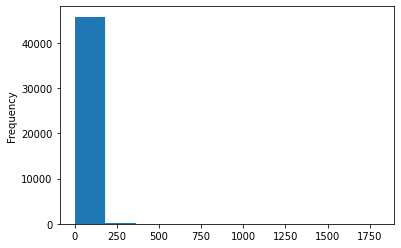

In [30]:
amazon_labelled.text.apply(lambda x:len(x.split())).plot(kind = 'hist')

In [31]:
apple_labelled['text_len'] = apple_labelled.text.apply(lambda x:len(x.split()))

In [32]:
apple_labelled.describe()

,label,text_len
count,424002.000000,424002.000000
mean,0.518332,13.407406
std,0.499664,26.591489
min,0.000000,1.000000
25%,0.000000,8.000000
50%,1.000000,11.000000
75%,1.000000,16.000000
max,1.000000,1806.000000


In [33]:
apple_labelled = apple_labelled.drop('text_len', axis = 1)

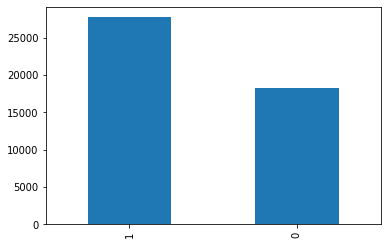

In [34]:
amazon_labelled.label.value_counts().plot(kind='bar')

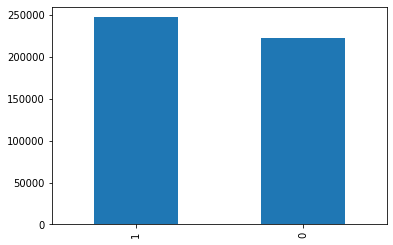

In [35]:
data.label.value_counts().plot(kind='bar')

###Train-Val-Test Split

In [11]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size = 0.33, random_state = 42)

val, test = train_test_split(test, test_size = 0.5, random_state = 42 )

In [12]:
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)
val.reset_index(drop=True, inplace=True)

###Preparing BERT Model

In [85]:
PREPROCESS_HANDLE = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
ENCODER_HANDLE = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3'

# PREPROCESS_HANDLE = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
# ENCODER_HANDLE = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1'

# PREPROCESS_HANDLE = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
# ENCODER_HANDLE = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1'

In [86]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optmizer

import matplotlib.pyplot as plt

In [ ]:
bert_preprocess_model = hub.KerasLayer(PREPROCESS_HANDLE)
bert_model = hub.KerasLayer(ENCODER_HANDLE)

In [88]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(PREPROCESS_HANDLE, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(ENCODER_HANDLE, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [89]:
classifier_model = build_classifier_model()

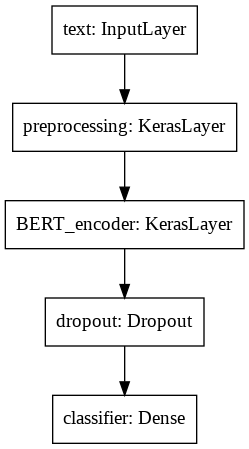

In [90]:
tf.keras.utils.plot_model(classifier_model)

In [91]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [92]:
epochs = 4
steps_per_epoch = len(train)
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [93]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

###Training the model

In [ ]:
print(f'Training model with {ENCODER_HANDLE}')
history = classifier_model.fit(x=train.text, y = train.label,
                               validation_data=(val.text, val.label),
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 1/4
8782/8782 [==============================] - 8361s 950ms/step - loss: 0.3878 - binary_accuracy: 0.8157 - val_loss: 0.0897 - val_binary_accuracy: 0.9684
Epoch 2/4
8782/8782 [==============================] - 8330s 949ms/step - loss: 0.0969 - binary_accuracy: 0.9664 - val_loss: 0.1236 - val_binary_accuracy: 0.9626
Epoch 3/4
6993/8782 [======================>.......] - ETA: 26:01 - loss: 0.0703 - binary_accuracy: 0.9742

###Serializing the trained model

In [94]:
dataset_name = 'news_stock_sentences_all_data_final'
saved_model_path = '/content/drive/MyDrive/ASU/CSE573/project/saved_models/{}_bert'.format(dataset_name.replace('/', '_'))

In [49]:
classifier_model.save(saved_model_path, include_optimizer=False)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/ASU/CSE573/project/saved_models/news_stock_sentences_new_data_bert/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ASU/CSE573/project/saved_models/news_stock_sentences_new_data_bert/assets


###Model Evaluation

In [ ]:
loss, accuracy = classifier_model.evaluate(test.text, test.label)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

###Curves

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


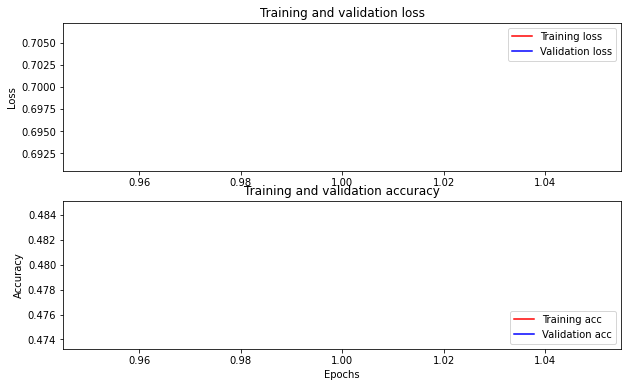

In [51]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

###Metrics

In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


In [38]:
predictions = classifier_model.predict(test.text)
sig_preds = tf.sigmoid(predictions)
sig_preds = np.where(sig_preds>=0.5, 1, 0)


In [39]:
print(classification_report(test.label, sig_preds))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     48761
           1       0.94      0.99      0.97     20442

    accuracy                           0.98     69203
   macro avg       0.97      0.98      0.98     69203
weighted avg       0.98      0.98      0.98     69203



In [40]:
print(confusion_matrix(test.label, sig_preds))

[[47564  1197]
 [  190 20252]]


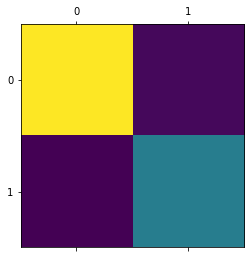

In [41]:
plt.matshow(confusion_matrix(test.label, sig_preds))
plt.show()

###Reloading the model from serialized state

In [16]:
from keras.models import load_model

In [17]:
reloaded_model = load_model(saved_model_path)

###Evaluating the relaoded model

In [18]:
predictions = reloaded_model.predict(test.text)
sig_preds = tf.sigmoid(predictions)
sig_preds = np.where(sig_preds>=0.5, 1, 0)


In [21]:
print(classification_report(test.label, sig_preds))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     48458
           1       0.94      0.99      0.97     20746

    accuracy                           0.98     69204
   macro avg       0.97      0.98      0.98     69204
weighted avg       0.98      0.98      0.98     69204



In [22]:
posterior_prob = tf.sigmoid(reloaded_model.predict(['one end pricey featurerich smartwatch like appl cheap singlepurpos made xiaomi']))
prediction_class = 1 if posterior_prob > 0.5 else 0
print(prediction_class)

0


###Creating an API Enpoint for Inference from Model

In [ ]:
!pip install colabcode

In [ ]:
!pip install fastapi


In [23]:
import unicodedata
import re
nltk.download('stopwords')
nltk.download('punkt')
stopwords = nltk.corpus.stopwords.words('english')
from nltk.stem import LancasterStemmer,PorterStemmer


def nonAsciiChar(words):
    words_list=[]
    for w in words:
        w=re.sub('[^a-zA-Z]+','',re.sub(r'[\W\d]','',w.lower()))
        format_words=unicodedata.normalize('NFKD', w).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        words_list.append(format_words)
        
    return words_list
def stemWordsRemoval(words):
    stemmer = PorterStemmer()
    words_list=[]
    for word in words:
        word=stemmer.stem(word)
        if word not in words_list:
            words_list.append(word)
    return words_list

def stopWordsRemoval(words):
    words_list=[]
    for w in words:
        if w not in stopwords:
            words_list.append(w)
    return words_list

def removeLinks(words):
    words_list=[]
    for w in words:
        if not re.match('[www]',w):
            words_list.append(w)
    return words_list

def spaceRemoval(words):
    words_list=[]
    for w in words:
        if w!='':
            words_list.append(w)
    return words_list


def dataExtraction(words):
    words=nonAsciiChar(words)
    words=spaceRemoval(words)
    words=stopWordsRemoval(words)
    words=stemWordsRemoval(words)
    words=removeLinks(words)
    return words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [65]:
def get_sentences(news_article):
    paragraphs = nltk.sent_tokenize(news_article.lower())
    sentences=[]
    is_amazon = []
    amzn_sentences = []
    apple_sentences = []
    key_words=['amazon','apple','aapl','amzn']
    amazon_keywords = ['amazon', 'amzn']
    apple_keywords = ['apple', 'aapl']

    for para in paragraphs:
      sentences_list = para.split("\n")
      for sentence in sentences_list:
        if any(key in sentence for key in amazon_keywords):
          sentences.append(sentence)
          is_amazon.append(1)
        if any(key in sentence for key in apple_keywords):
          sentences.append(sentence)
          is_amazon.append(0)
          # if any(key in sentence for key in key_words):
          #   sentences.append(sentence)


    if len(sentences) == 0:
      return None
    
    sentences_df = pd.DataFrame({'text':sentences, 'is_amazon':is_amazon})

    sentences_df=sentences_df[sentences_df['text'].str.match('^[A-Z a-z 0-9]+')]

    sentences_df=sentences_df.drop_duplicates(keep=False).reset_index(drop=True)

    sentences_df['words'] = sentences_df.text.apply(word_tokenize)
    sentences_df['words'] = sentences_df.words.apply(dataExtraction)
    sentences_df['text'] = sentences_df.words.apply(lambda words: " ".join(words))
    sentences_df = sentences_df.drop(columns="words")

    return sentences_df

In [66]:
from pydantic import BaseModel
from fastapi import FastAPI

In [67]:
from fastapi.middleware.cors import CORSMiddleware

In [68]:
class Sentence(BaseModel):
  news_article:str

In [69]:
class Prediction(BaseModel):
  prediction_apple:str
  confidence_apple:str
  prediction_amazon:str
  confidence_amazon:str


In [80]:
app = FastAPI()

In [81]:
app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"],
    allow_credentials=True,
    allow_methods=["*"],
    allow_headers=["*"],
)

In [82]:
@app.on_event("startup")
def load_model_from_file():
  global inference_model
  inference_model = load_model(saved_model_path)


@app.get('/')
def index():
  return{'message':'Post an article to this API to get inference'}

@app.post('/predict')
def classify_sentence(data:Sentence):
  received_data = data.dict()
  news_article = received_data['news_article']
  sentences = get_sentences(news_article)
  prediction_class_amzn = "-1"
  prediction_class_apple = "-1"
  confidence_amzn = '0'
  confidence_apple = '0'

  if sentences is None:
    p = Prediction(prediction_apple=prediction_class_apple, confidence_apple=confidence_apple, prediction_amazon = prediction_class_amzn, confidence_amazon=confidence_amzn)
    return p


  amazon_sentences = sentences[sentences['is_amazon'] == 1].text
  apple_sentences = sentences[sentences['is_amazon'] == 0].text

  # posterior_prob = tf.sigmoid(inference_model.predict(sentences))

  if(len(amazon_sentences) != 0):
    posterior_prob_amzn = tf.sigmoid(inference_model.predict(amazon_sentences))
    prediction_class_amzn = np.where(posterior_prob_amzn>0.5, 1, 0)
    bin_count_amzn = np.bincount(prediction_class_amzn.flatten())

    prediction_class_amzn = np.bincount(prediction_class_amzn.flatten()).argmax()

    confidence_amzn = bin_count_amzn[prediction_class_amzn]/np.sum(bin_count_amzn)
    confidence_amzn = str(confidence_amzn)
    prediction_class_amzn = str(prediction_class_amzn)


  if(len(apple_sentences) != 0):
    posterior_prob_apple = tf.sigmoid(inference_model.predict(apple_sentences))
    prediction_class_apple = np.where(posterior_prob_apple>0.5, 1, 0)
    bin_count_apple = np.bincount(prediction_class_apple.flatten())

    prediction_class_apple = np.bincount(prediction_class_apple.flatten()).argmax()

    confidence_apple = bin_count_apple[prediction_class_apple]/np.sum(bin_count_apple)
    prediction_class_apple = str(prediction_class_apple)
    confidence_apple = str(confidence_apple)

  # prediction_classes = np.where(posterior_prob>0.5, 1, 0)

  # print(prediction_classes)
  # prediction_class = np.bincount(prediction_classes.flatten()).argmax()
  # p = Prediction(prediction=str(prediction_class))
  p = Prediction(prediction_apple=prediction_class_apple, confidence_apple=confidence_apple, prediction_amazon = prediction_class_amzn, confidence_amazon=confidence_amzn)

  return p

In [83]:
from colabcode import ColabCode
server = ColabCode(port=10000, code=False)

In [ ]:
server.run_app(app)